In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PCA import PCA_Component

data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

## Plot residuals for 1 signal for different number of n_components

31


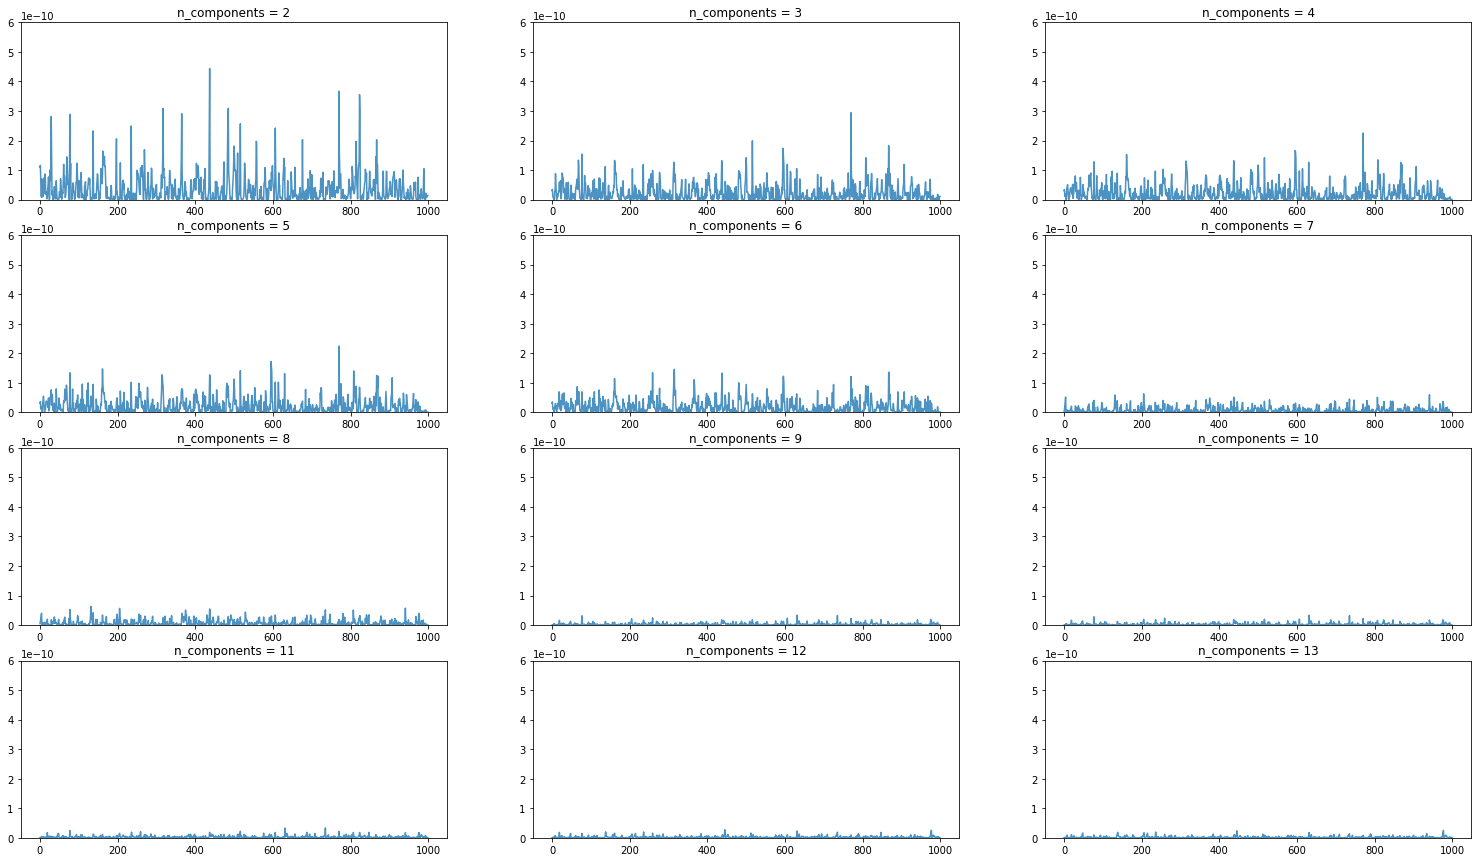

In [2]:

signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
X = data_1[signals].to_numpy()

signal_to_PLOT = signals.index('P_J280') # selected P_J280 because shows importance
print(signal_to_PLOT)
pca = PCA_Component()
pca.set_X(X)

f, axs = plt.subplots(4,3,figsize =(26, 15))
for i in range(12):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    R = pca.calculate_residual(X)
    s = R[:,signal_to_PLOT]

    axs[int(i/3), i%3].set_title("n_components = " + str(n_components))
    axs[int(i/3), i%3].plot(range(1000), s[0:1000], alpha = 0.8)
    axs[int(i/3), i%3].set_ylim((0,6e-10)) # consistent y-axis


### Choosing `n_components`
We will use the mean and standard deviation of anomaly score (the probability of a row being an anomaly) to choose. The anomaly score should be low for normal data and high for data we know is outlier. Moreover, we can split `data 2` in two parts (inlier and outlier) to see that it firs the inliers as normal data.

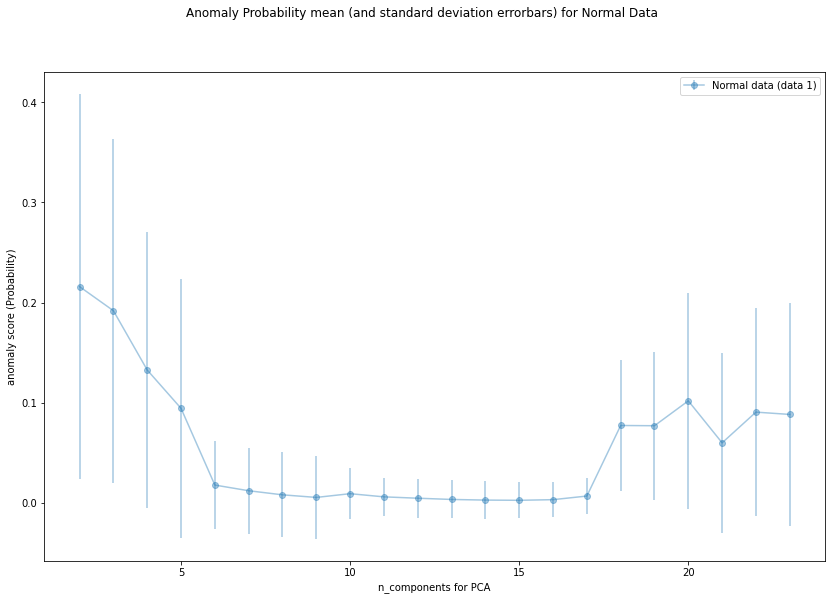

In [3]:
pca = PCA_Component()
pca.set_X(X)

per_n_components = []
for i in range(22):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(X)
    per_n_components.append(score)
    
mean_ = np.mean(per_n_components, axis=1)
std_ = np.std(per_n_components, axis=1)

fig = plt.figure(figsize=(14, 9))
fig.suptitle("Anomaly Probability mean (and standard deviation errorbars) for Normal Data")
plt.errorbar(x=range(2, 24), y=mean_, yerr=std_, fmt='o-', alpha = 0.4, label="Normal data (data 1)")
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.ylim((0,0.5)) # consistent y-axis
plt.legend()
plt.show()

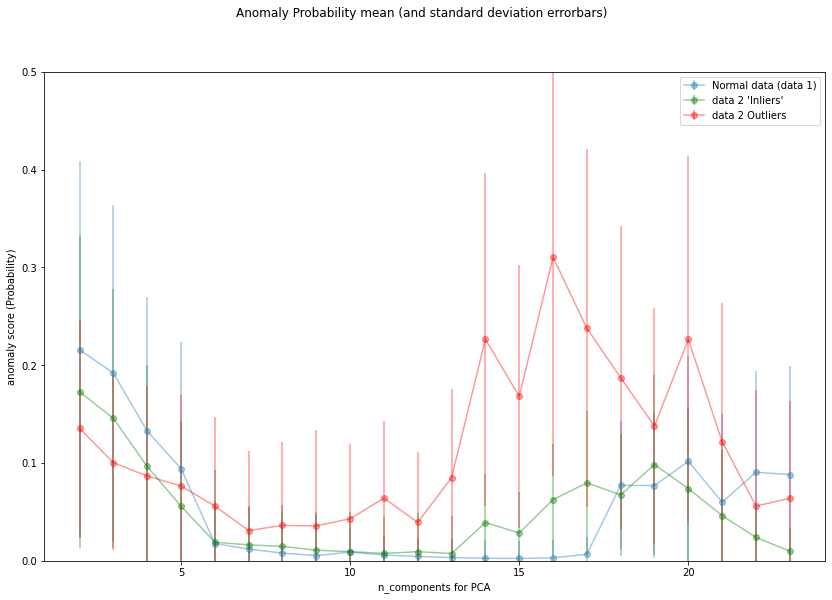

In [5]:
pca = PCA_Component()
pca.set_X(X) # fit for normal data
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]
Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]

per_n_components_outlier = []
per_n_components_inlier = []
for i in range(22):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(Z_outliers)
    per_n_components_outlier.append(score)
    score = pca.anomaly_score(Z_inliers)
    per_n_components_inlier.append(score)
    
mean_outlier = np.mean(per_n_components_outlier, axis=1)
std_outlier = np.std(per_n_components_outlier, axis=1)
mean_inlier = np.mean(per_n_components_inlier, axis=1)
std_inlier = np.std(per_n_components_inlier, axis=1)


fig = plt.figure(figsize=(14, 9))
fig.suptitle("Anomaly Probability mean (and standard deviation errorbars)")
plt.errorbar(x=range(2, 24), y=mean_, yerr=std_, fmt='o-', alpha=0.4, label="Normal data (data 1)")
plt.errorbar(x=range(2, 24), y=mean_inlier, yerr=std_inlier, fmt='o-', alpha=0.4, c='g', label="data 2 'Inliers'")
plt.errorbar(x=range(2, 24), y=mean_outlier, yerr=std_outlier, fmt='o-', alpha=0.4,c='r', label="data 2 Outliers")
plt.ylim((0,0.5)) # consistent y-axis
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.legend()
plt.show()